# downstream DESeq analysis with `bedtools multicov` counts

## investigating hypoxic control treatment

this treatment resulted in 3 pairwise comparisons with DMGs - interested if all of these DMGs are unique to hypoxia control (HC)

In [3]:
library(tidyverse)
library(ggvenn)
library(dplyr)
library(RColorBrewer)

###### for KEGG analysis ######
library(topGO)
library(KEGGREST)
library(clusterProfiler)
library(ggridges)
library(httr)

### loading and formatting

In [4]:
# importing csv files

#1 control control vs. hypoxic control
CC_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/HC_CC.csv')

#2 control hypoxic vs. hypoxic control
CH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/HC_CH.csv')

#3 hypoxic hypoxic vs. hypoxic control
HH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/HC_HH.csv')

#######################################

#4 hypoxic hypoxic vs. control hypoxic
HH_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/HH_HC.csv')

#5 hypoxic hypoxic vs. control control
HH_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/CC_HH.csv')

#6 control control vs. control hypoxic
CC_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/CC_CH.csv')


pulling out significant DMGs for the three pairwise comparisons with HC (adjusted p-value < 0.05)

In [5]:
# significant DMGs

# 1. control control vs. hypoxic control
sig_CC_HC <- filter(CC_HC, CC_HC$padj < 0.05)
dim(sig_CC_HC) # 20 total sig DMGs

# 2. control hypoxic vs. hypoxic control
sig_CH_HC <- filter(CH_HC, CH_HC$padj < 0.05)
dim(sig_CH_HC) # 258 total sig DMGs

# 3. hypoxic hypoxic vs. hypoxic control
sig_HH_HC <- filter(HH_HC, HH_HC$padj < 0.05)
dim(sig_HH_HC) # 124 total sig DMGs

[1] 15  7

[1] 203   7

[1] 0 7

In [6]:
# significant DMGs

# 4. hypoxic hypoxic vs. control hypoxic
sig_HH_CH <- filter(HH_CH, HH_CH$padj < 0.05)
dim(sig_HH_CH) # 0 total sig DMGs

# 5. hypoxic hypoxic vs. control control
sig_HH_CC <- filter(HH_CC, HH_CC$padj < 0.05)
dim(sig_HH_CC) # 2 total sig DMGs

# 6. control control vs. control hypoxic
sig_CC_CH <- filter(CC_CH, CC_CH$padj < 0.05)
dim(sig_CC_CH) # 1 total sig DMGs

[1] 0 7

[1] 2 7

[1] 1 7

adding columns to the dfs - need to assign which direction the methylation is in order to assign colors in the plots - also adding a column to denote what the pairwise comparison is in case I end up combining dataframes and faceting by this later on... 

In [7]:
# column 'pair' to denote the pairwise comparison this data is originally from 
CC_HC$pair <- 'CC_HC' #1
CH_HC$pair <- 'CH_HC' #2
HH_HC$pair <- 'HH_HC' #3
HH_CH$pair <- 'HH_CH' #4
HH_CC$pair <- 'HH_CC' #5
CC_CH$pair <- 'CC_CH' #6

In [8]:
#1 control control vs. hypoxic control
CC_HC$methyl <- ifelse(CC_HC$log2FoldChange<0 & CC_HC$padj < 0.05, "CC", 
                        ifelse(CC_HC$log2FoldChange>0 & CC_HC$padj < 0.05, "HC", 
                               "not significant"))

#2 control hypoxic vs. hypoxic control
CH_HC$methyl <- ifelse(CH_HC$log2FoldChange<0 & CH_HC$padj < 0.05, "CH", 
                        ifelse(CH_HC$log2FoldChange>0 & CH_HC$padj < 0.05, "HC", 
                               "not significant"))

#3 hypoxic hypoxic vs. hypoxic control
HH_HC$methyl <- ifelse(HH_HC$log2FoldChange<0 & HH_HC$padj < 0.05, "HC", 
                        ifelse(HH_HC$log2FoldChange>0 & HH_HC$padj < 0.05, "HH", 
                               "not significant"))

#4 hypoxic hypoxic vs. control hypoxic
HH_CH$methyl <- ifelse(HH_CH$log2FoldChange<0 & HH_CH$padj < 0.05, "CH",
                        ifelse(HH_CH$log2FoldChange>0 & HH_CH$padj < 0.05, "HH", 
                               "not significant"))

#5 hypoxic hypoxic vs. control control
HH_CC$methyl <- ifelse(HH_CC$log2FoldChange<0 & HH_CC$padj < 0.05, "CC", 
                        ifelse(HH_CC$log2FoldChange>0 & HH_CC$padj < 0.05, "HH", 
                               "not significant"))



#6 control control vs. control hypoxic
CC_CH$methyl <- ifelse(CC_CH$log2FoldChange<0 & CC_CH$padj < 0.05, "CC", 
                        ifelse(CC_CH$log2FoldChange>0 & CC_CH$padj < 0.05, "CH", 
                               "not significant"))


### add gene names/meta data to significant DMGs in pairwise comparisons

From the Index of *C. virginica* genomes/annotations page ([link](https://ftp.ncbi.nlm.nih.gov/genomes/all/annotation_releases/6565/100/GCF_002022765.2_C_virginica-3.0/))

I downloaded the file `GCF_002022765.2_C_virginica-3.0_feature_table` - since only the mRNA lines had gene names (gene products), I first removed empty rows for those and then removed duplicate rows for the gene_id - that csv is what is being loaded here, with the idea that I can provide a list of sig. genes from a pairwise comparison and add gene names to that list

In [9]:
gene_products <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/GCF_CV_gene_products.csv')
head(gene_products)

,X..feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non.redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<int>,<lgl>,<int>,<int>,<chr>
1,gene,lncRNA,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,13578,14594,+,,NA,,,LOC111116054,111116054,NA,1017,NA,
2,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,28961,33324,+,XM_022471938.1,NA,XP_022327646.1,UNC5C-like protein,LOC111126949,111126949,NA,2254,2254,
3,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,43111,66897,-,XM_022447324.1,NA,XP_022303032.1,"FMRFamide receptor-like, transcript variant X1",LOC111110729,111110729,NA,1489,1489,
4,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,85606,95254,-,XM_022449924.1,NA,XP_022305632.1,homeobox protein Hox-B7-like,LOC111112434,111112434,NA,1023,1023,
5,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,99840,106460,+,XM_022461698.1,NA,XP_022317406.1,ribulose-phosphate 3-epimerase-like,LOC111120752,111120752,NA,1070,1070,
6,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,108305,110077,-,XM_022474921.1,NA,XP_022330629.1,mucin-19-like,LOC111128944,111128944,NA,1773,1773,partial


In [10]:
# 1. control control vs. hypoxic control
#gene_products[gene_products$symbol %in% sig_CC_HC$X,]

colnames(sig_CC_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CC_HC_genes <- merge(sig_CC_HC, gene_products, by='symbol')
sig_CC_HC_genes <- select(sig_CC_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_CC_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/sig_CC_HC_genes.csv')


head(sig_CC_HC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099932,63.22022,1.254333,0.2374474,4.229709,2.339940e-05,0.024563974,exostosin-1a-like
2,LOC111101872,51.68899,-1.437766,0.2777422,-4.276504,1.898509e-05,0.023553598,"DNA ligase 1-like, transcript variant X3"
3,LOC111103344,1000.68234,-1.197207,0.2151155,-4.403251,1.066404e-05,0.019989772,"uncharacterized LOC111103344, transcript variant X7"
4,LOC111113022,45.87158,-1.631019,0.3259323,-4.237134,2.263908e-05,0.024563974,uncharacterized protein KIAA0930 homolog
5,LOC111115023,40.66722,-1.394704,0.2789387,-4.103782,4.064501e-05,0.036978828,uncharacterized LOC111115023
6,LOC111115924,10.86816,-2.025111,0.3651334,-4.861541,1.164752e-06,0.005298456,uncharacterized LOC111115924


In [11]:
# 2. control hypoxic vs. hypoxic control
colnames(sig_CH_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CH_HC_genes <- merge(sig_CH_HC, gene_products, by='symbol')
sig_CH_HC_genes <- select(sig_CH_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_CH_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/sig_CH_HC_genes.csv')

head(sig_CH_HC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,85.93418,-1.268455,0.2026576,-5.025496,5.021318e-07,0.0002389426,kinesin-like protein KIF17
2,LOC111099571,62.21809,-1.386573,0.3153413,-3.604263,3.130394e-04,0.0282899359,histone RNA hairpin-binding protein-like
3,LOC111099930,71.33578,-1.158577,0.2188639,-4.151335,3.305415e-05,0.0066571068,"uncharacterized LOC111099930, transcript variant X1"
4,LOC111099978,74.25643,1.209614,0.2629301,3.649694,2.625531e-04,0.0266293052,"oncoprotein-induced transcript 3 protein-like, transcript variant X1"
5,LOC111100608,45.79652,-1.471241,0.2906827,-4.201284,2.654052e-05,0.0058665565,DDRGK domain-containing protein 1-like
6,LOC111100625,76.87966,-1.218647,0.2664359,-3.635574,2.773624e-04,0.0275258395,"succinate dehydrogenase [ubiquinone] flavoprotein subunit, mitochondrial-like, transcript variant X2"


In [12]:
# 3. hypoxic hypoxic vs. hypoxic control
colnames(sig_HH_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_HH_HC_genes <- merge(sig_HH_HC, gene_products, by='symbol')
sig_HH_HC_genes <- select(sig_HH_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_HH_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/sig_HH_HC_genes.csv')

head(sig_HH_HC_genes)

symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>


4. hypoxic hypoxic vs. control hypoxic

no sig. DMGs


In [13]:
# 5. hypoxic hypoxic vs. control control
colnames(sig_HH_CC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_HH_CC_genes <- merge(sig_HH_CC, gene_products, by='symbol')
sig_HH_CC_genes <- select(sig_HH_CC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_HH_CC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/sig_HH_CC_genes.csv')

head(sig_HH_CC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111100699,27.20447,2.370275,0.3751041,5.652497,1.581336e-08,0.000405581,methylthioribulose-1-phosphate dehydratase-like
2,LOC111117306,33.84992,-2.018712,0.3786534,-4.671058,2.996520e-06,0.038427367,zinc finger protein 239-like


In [15]:
# 6. control control vs. control hypoxic
colnames(sig_CC_CH) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CC_CH_genes <- merge(sig_CC_CH, gene_products, by='symbol')
sig_CC_CH_genes <- select(sig_CC_CH_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_CC_CH_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs//sig_CC_CH_genes.csv')

head(sig_CC_CH_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111100699,27.20447,2.208434,0.3778965,5.18246,2.189788e-07,0.005616368,methylthioribulose-1-phosphate dehydratase-like


### overlap of sig. DMGs in pairwise comparisons

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


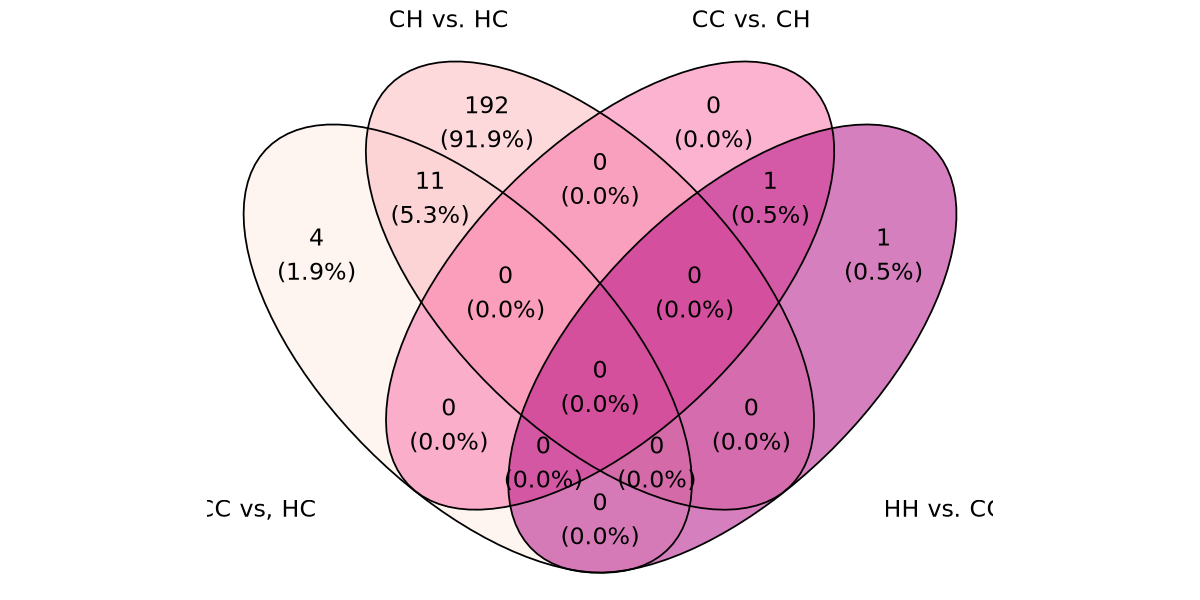

In [21]:
options(repr.plot.width=10, repr.plot.height=5)

x = list(A = sig_CC_HC$symbol,
         #B = sig_HH_HC$symbol, no sig DMG
         C = sig_CH_HC$symbol,
        D = sig_CC_CH$symbol,
        E = sig_HH_CC$symbol)

names(x) <- c('CC vs, HC', 
              #'HH vs. HC', no sig. DMG
              'CH vs. HC', 
              'CC vs. CH', 
              'HH vs. CC')

cpg_venn <- ggvenn(x,
      set_name_size = 5,
       text_size = 5,
      stroke_size = 0.5, 
       show_percentage = TRUE) + 
scale_fill_brewer(palette = "RdPu",  direction = 1) 

cpg_venn

### ggplot Volcano plots 
Volcano plots made with ggplot of the pairwise comparisons from DESeq2

In [22]:
# to change size of plots
options(repr.plot.width=10, repr.plot.height=5)

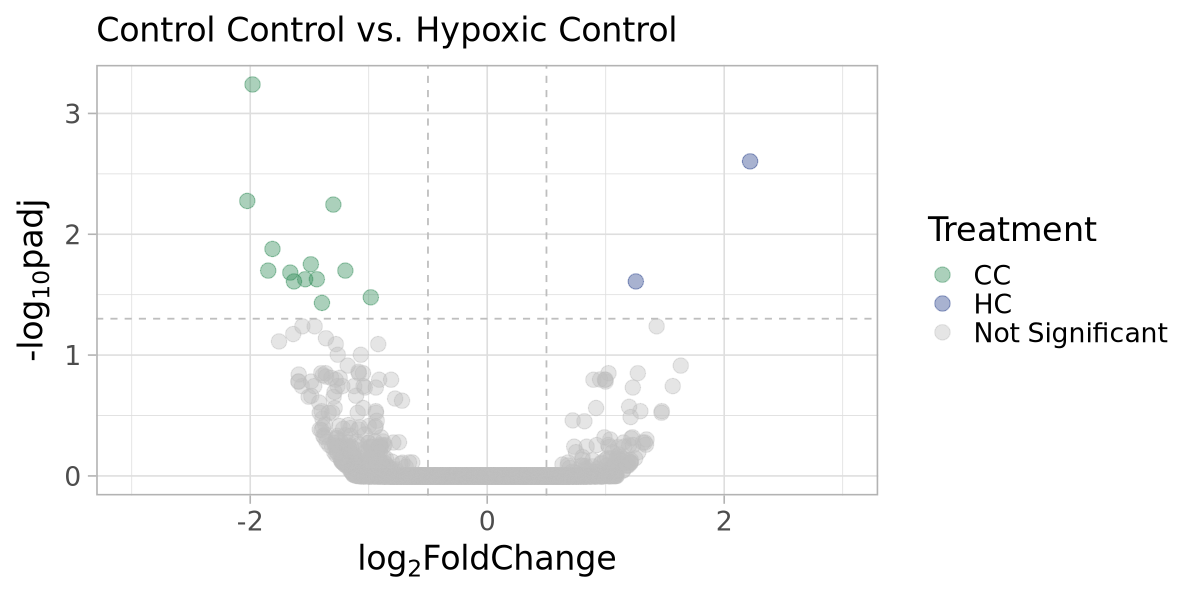

In [23]:
#1 control control vs. hypoxic control
CC_HC <- na.omit(CC_HC) # removing rows with NA for padj

volcano1 <- ggplot(data = CC_HC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('CC', 'HC', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                       labs(subtitle = 'Control Control vs. Hypoxic Control',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano1

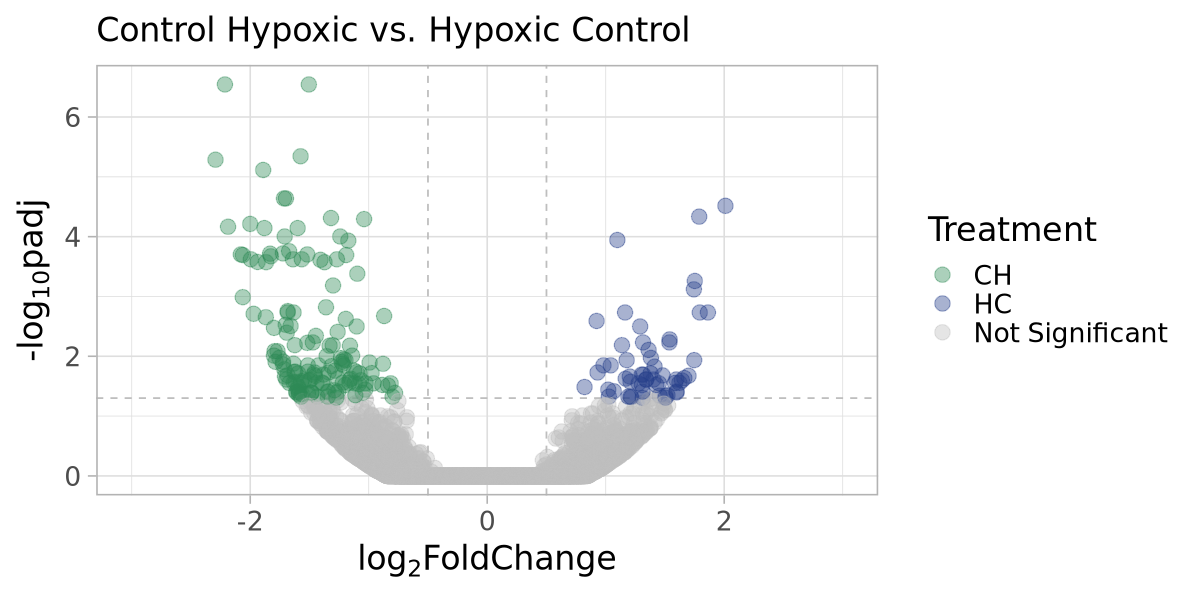

In [24]:
#2 control hypoxic vs. hypoxic control
CH_HC <- na.omit(CH_HC) # removing rows with NA for padj

volcano2 <- ggplot(data = CH_HC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('CH', 'HC', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Control Hypoxic vs. Hypoxic Control',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano2

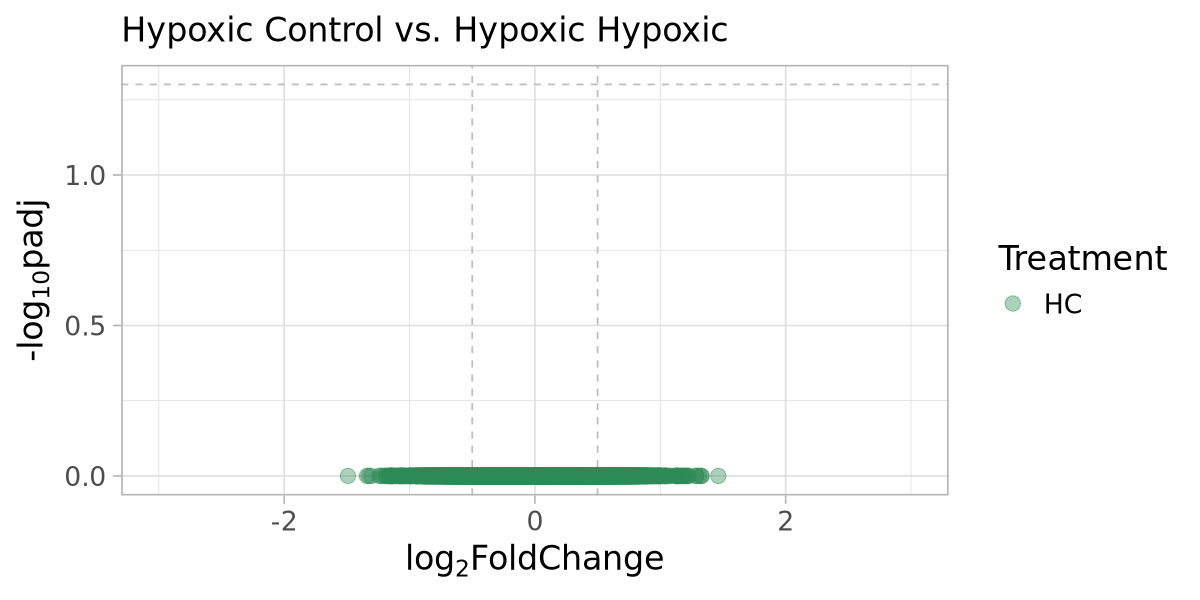

In [25]:
#3 hypoxic hypoxic vs. hypoxic control
HH_HC <- na.omit(HH_HC) # removing rows with NA for padj

volcano3 <- ggplot(data = HH_HC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('HC', 'HH', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Hypoxic Control vs. Hypoxic Hypoxic',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano3

want to actually flip the above plot so that HC is on the right and HH is on the left - to do this, make pos. LFC to neg and vice versa

In [26]:
# Switch the signs
HH_HC_flip <- HH_HC %>%
  mutate(log2FoldChange = -log2FoldChange)

HH_HC_flip$methyl <- ifelse(HH_HC_flip$log2FoldChange<0 & HH_HC_flip$padj < 0.05, "HH", 
                        ifelse(HH_HC_flip$log2FoldChange>0 & HH_HC_flip$padj < 0.05, "HC", 
                               "not significant"))

# View the modified dataframe
head(HH_HC_flip)
head(HH_HC)


,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pair,methyl
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,LOC111116054,0.06059123,-0.006860345,0.1386943,0.0000000,1.0000000,1,HH_HC,not significant
2,LOC111126949,0.04661633,0.000000000,0.1386943,0.0000000,1.0000000,1,HH_HC,not significant
3,LOC111110729,0.48614036,0.048102907,0.1414155,0.0000000,1.0000000,1,HH_HC,not significant
4,LOC111112434,2.14074307,0.409647999,0.3230192,-0.4942368,0.6211389,1,HH_HC,not significant
5,LOC111120752,1.23455531,0.105338014,0.3016609,0.0000000,1.0000000,1,HH_HC,not significant
7,LOC111128953,0.14576725,-0.006311147,0.1388330,0.0000000,1.0000000,1,HH_HC,not significant


,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pair,methyl
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,LOC111116054,0.06059123,0.006860345,0.1386943,0.0000000,1.0000000,1,HH_HC,not significant
2,LOC111126949,0.04661633,0.000000000,0.1386943,0.0000000,1.0000000,1,HH_HC,not significant
3,LOC111110729,0.48614036,-0.048102907,0.1414155,0.0000000,1.0000000,1,HH_HC,not significant
4,LOC111112434,2.14074307,-0.409647999,0.3230192,-0.4942368,0.6211389,1,HH_HC,not significant
5,LOC111120752,1.23455531,-0.105338014,0.3016609,0.0000000,1.0000000,1,HH_HC,not significant
7,LOC111128953,0.14576725,0.006311147,0.1388330,0.0000000,1.0000000,1,HH_HC,not significant


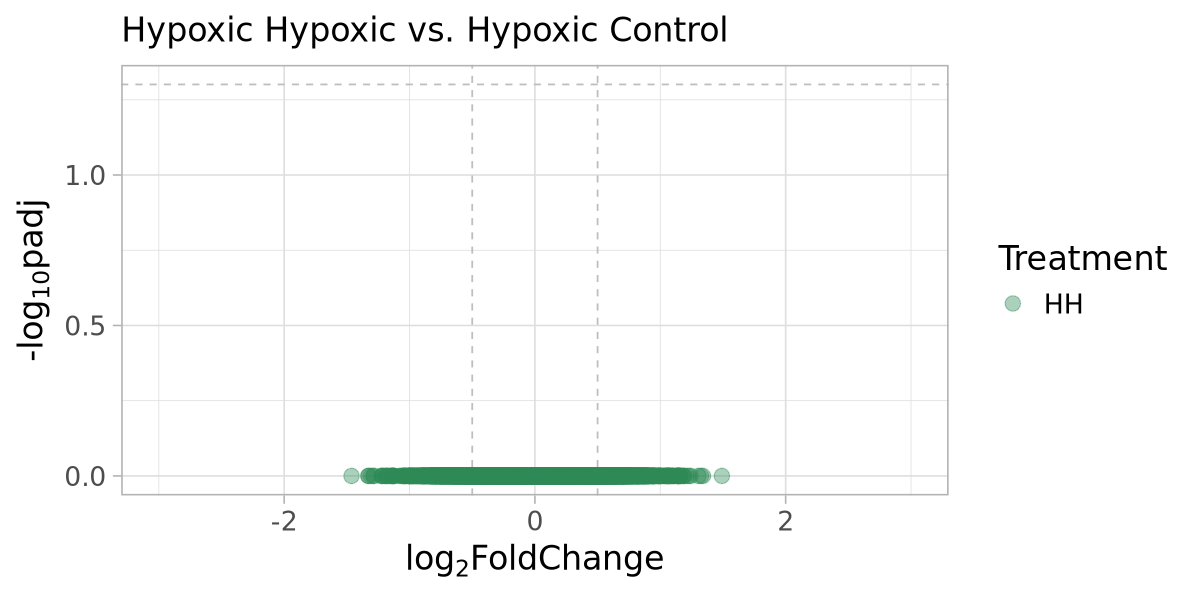

In [27]:
#3 hypoxic hypoxic vs. hypoxic control FLIPPED
volcano3.5 <- ggplot(data = HH_HC_flip, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('HH', 'HC', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Hypoxic Hypoxic vs. Hypoxic Control',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano3.5

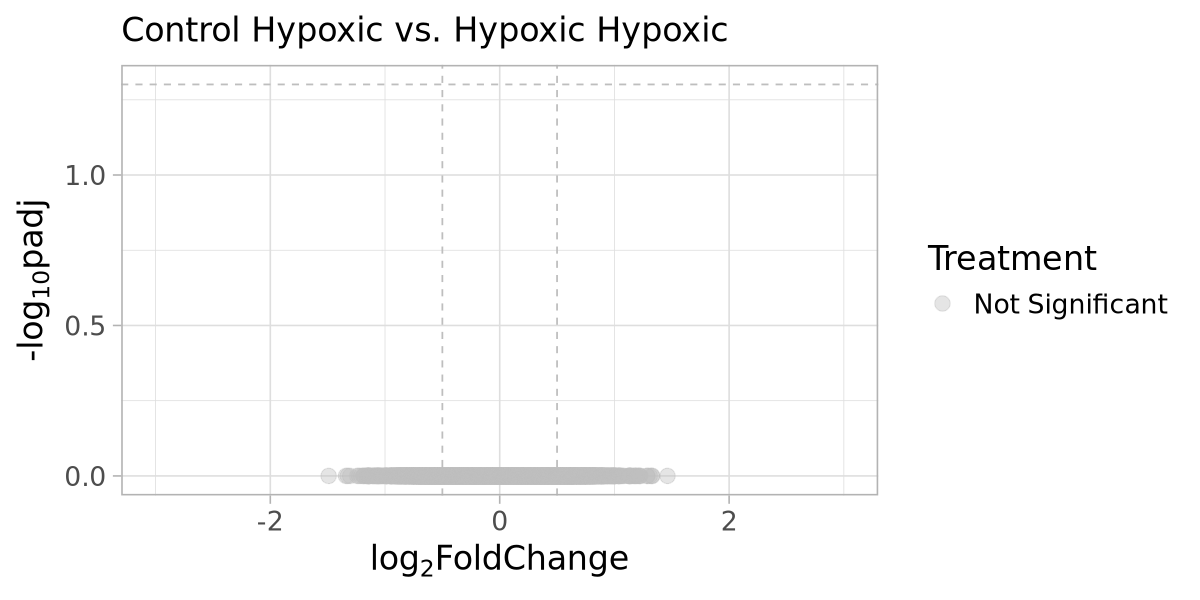

In [28]:
#4 hypoxic hypoxic vs. control hypoxic
HH_CH <- na.omit(HH_CH) # removing rows with NA for padj

volcano4 <- ggplot(data = HH_CH, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('gray'),
                                           labels=c('Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Control Hypoxic vs. Hypoxic Hypoxic',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano4

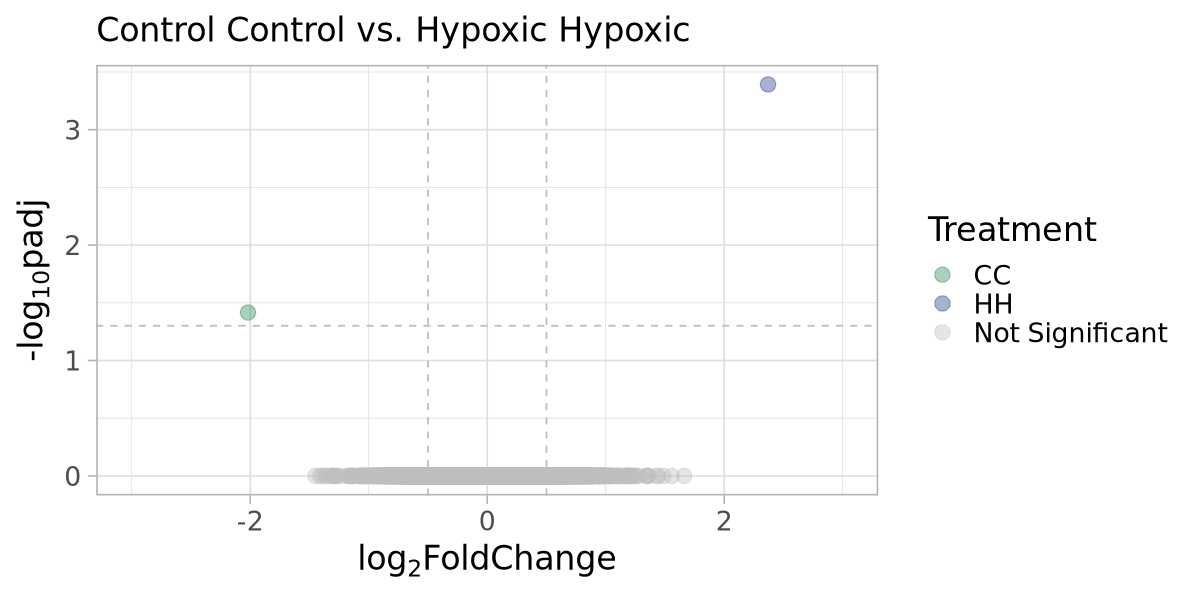

In [29]:
#5 hypoxic hypoxic vs. control control
HH_CC <- na.omit(HH_CC) # removing rows with NA for padj

volcano5 <- ggplot(data = HH_CC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('CC', 'HH', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Control Control vs. Hypoxic Hypoxic',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano5

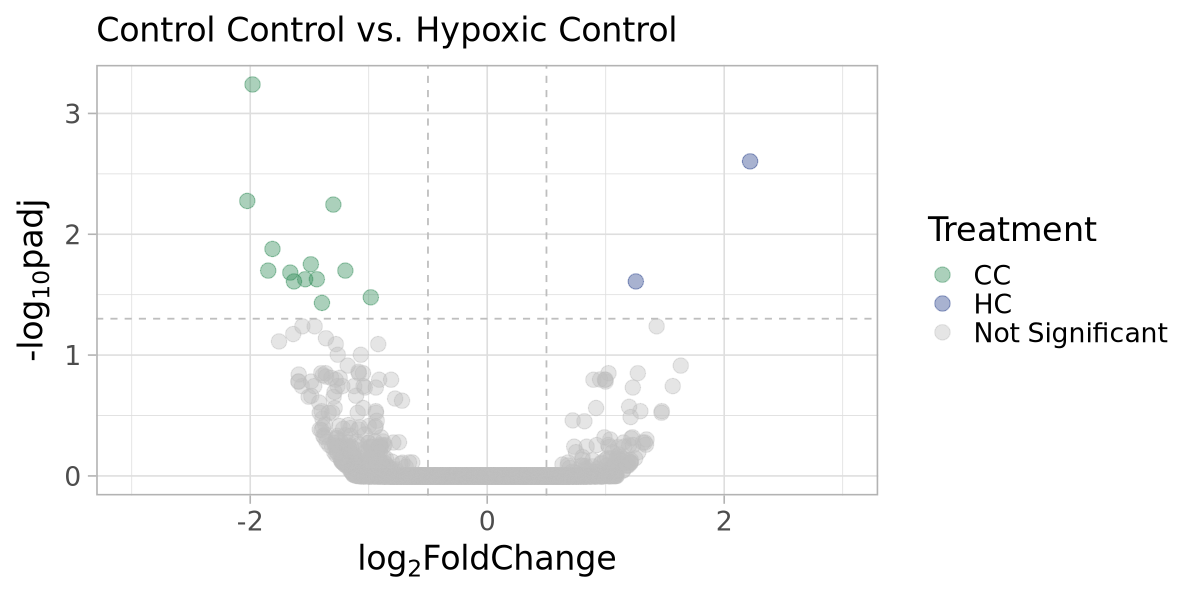

In [30]:
#6 control control vs. control hypoxic
CC_HC <- na.omit(CC_HC) # removing rows with NA for padj

volcano6 <- ggplot(data = CC_HC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('CC', 'HC', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Control Control vs. Hypoxic Control',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano6

putting all the data together into one ggplot grid...

In [31]:
mega_df <- na.omit(rbind(CC_HC, CH_HC, HH_HC_flip, HH_CH, HH_CC, CC_CH))
head(mega_df)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pair,methyl
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
17,LOC111109452,37.53788,-0.16159445,0.3819749,0.000000,1.0000000000,1.0000000,CC_HC,not significant
18,LOC111124802,435.37471,0.06934614,0.1304209,0.000000,1.0000000000,1.0000000,CC_HC,not significant
19,LOC111101273,159.36437,-0.13657031,0.1496973,0.000000,1.0000000000,1.0000000,CC_HC,not significant
20,LOC111101250,254.34149,-0.14666076,0.1937645,0.000000,1.0000000000,1.0000000,CC_HC,not significant
21,LOC111101262,557.40207,0.18550110,0.1224097,0.000000,1.0000000000,1.0000000,CC_HC,not significant
22,LOC111133260,94.62714,-0.91199336,0.1899085,-3.485853,0.0004905697,0.1599518,CC_HC,not significant


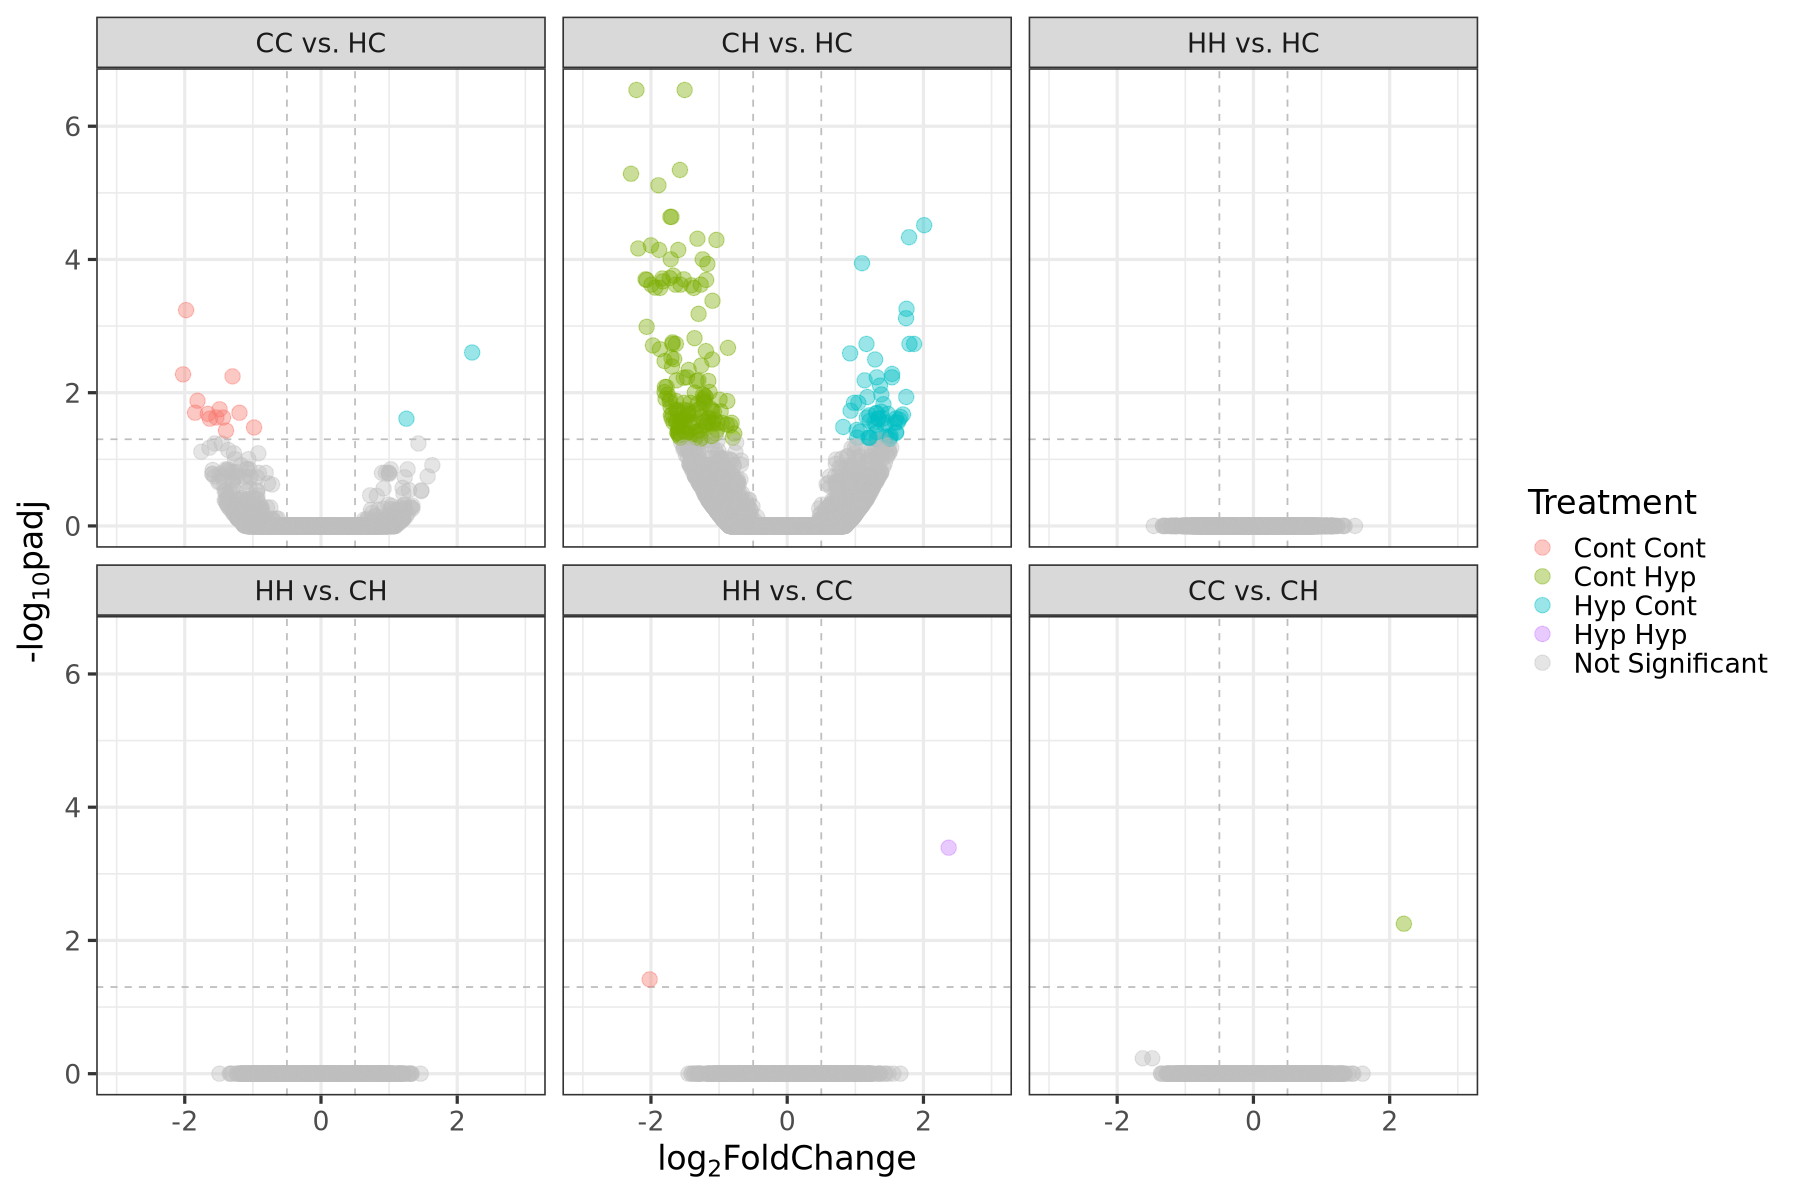

In [32]:
options(repr.plot.width=15, repr.plot.height=10)

# setting order of grids for facet_wrap
mega_df$pair <- factor(mega_df$pair, levels = c('CC_HC','CH_HC','HH_HC', 'HH_CH','HH_CC','CC_CH'))

# renaming grid labels
new_labels <- c(CC_HC = "CC vs. HC", 
                CH_HC = "CH vs. HC", 
                HH_HC = "HH vs. HC",
               HH_CH = "HH vs. CH",
               HH_CC = "HH vs. CC",
               CC_CH = "CC vs. CH")

volcano_MEGA <- ggplot(data = mega_df, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
scale_color_manual(values = c('#F8766D','#7CAE00', '#00BFC4', '#C77CFF', 'gray'),
                                           labels=c('Cont Cont','Cont Hyp', 'Hyp Cont', 'Hyp Hyp', 'Not Significant')) + 
facet_wrap(~pair, labeller = as_labeller(new_labels)) + 
                        theme_bw(base_size=20) + 
                        labs(col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano_MEGA

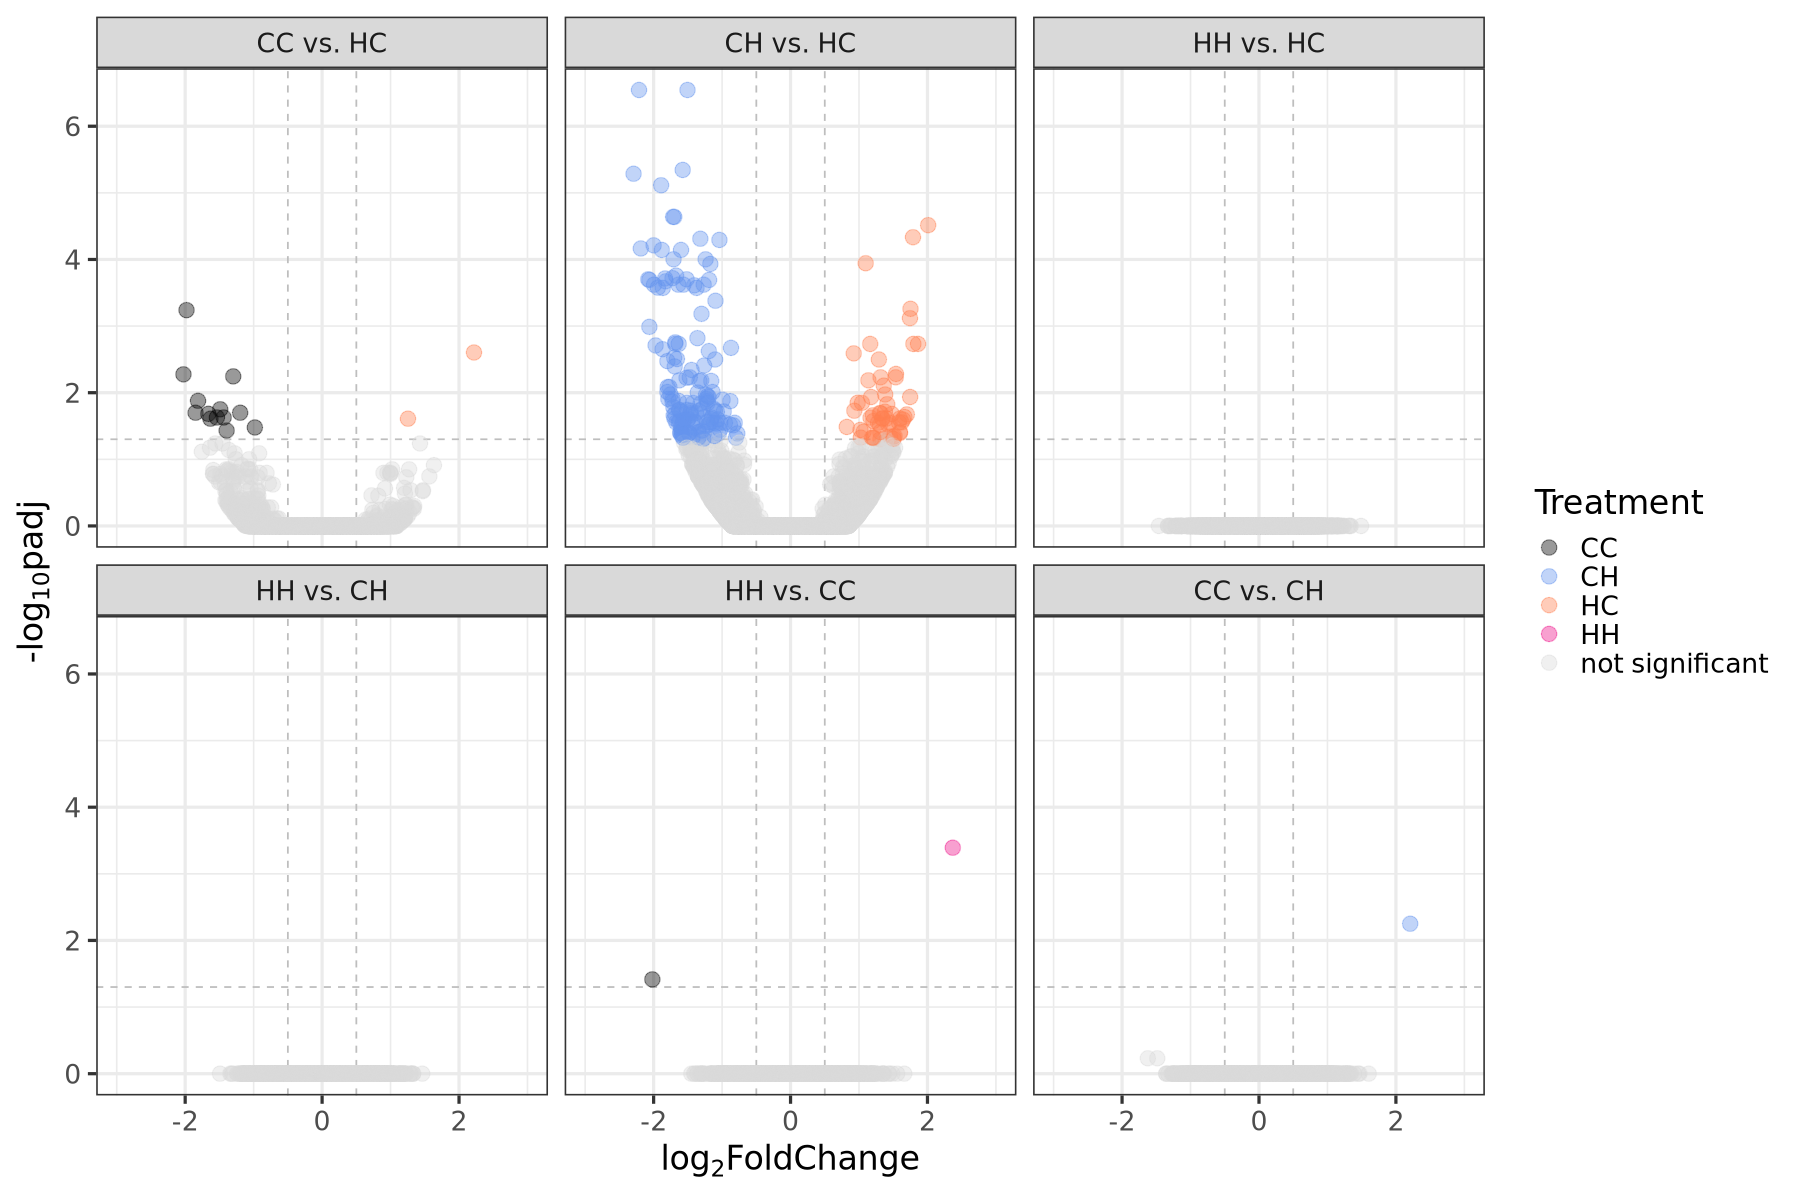

In [33]:
options(repr.plot.width=15, repr.plot.height=10)

# setting order of grids for facet_wrap
mega_df$pair <- factor(mega_df$pair, levels = c('CC_HC','CH_HC','HH_HC', 'HH_CH','HH_CC','CC_CH'))

# renaming grid labels
new_labels <- c(CC_HC = "CC vs. HC", 
                CH_HC = "CH vs. HC", 
                HH_HC = "HH vs. HC",
               HH_CH = "HH vs. CH",
               HH_CC = "HH vs. CC",
               CC_CH = "CC vs. CH")

volcano_MEGA <- ggplot(data = mega_df, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
scale_color_manual(values=c('black', 'cornflowerblue', 'coral','deeppink2', 'gray85')) +
#scale_color_manual(values = c('#E7E1EF','#C5B3E6', '#7A288A', '#4E0A6A', 'gray'),
                                           #labels=c('CC','CH', 'HC', 'HH', 'Not Significant')) + 
facet_wrap(~pair, labeller = as_labeller(new_labels)) + 
                        theme_bw(base_size=20) + 
                        labs(col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano_MEGA

In [34]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures/metaVolcano1.pdf', volcano_MEGA,
      width = 15, heigh = 10)

just adding another option for how things are labelled

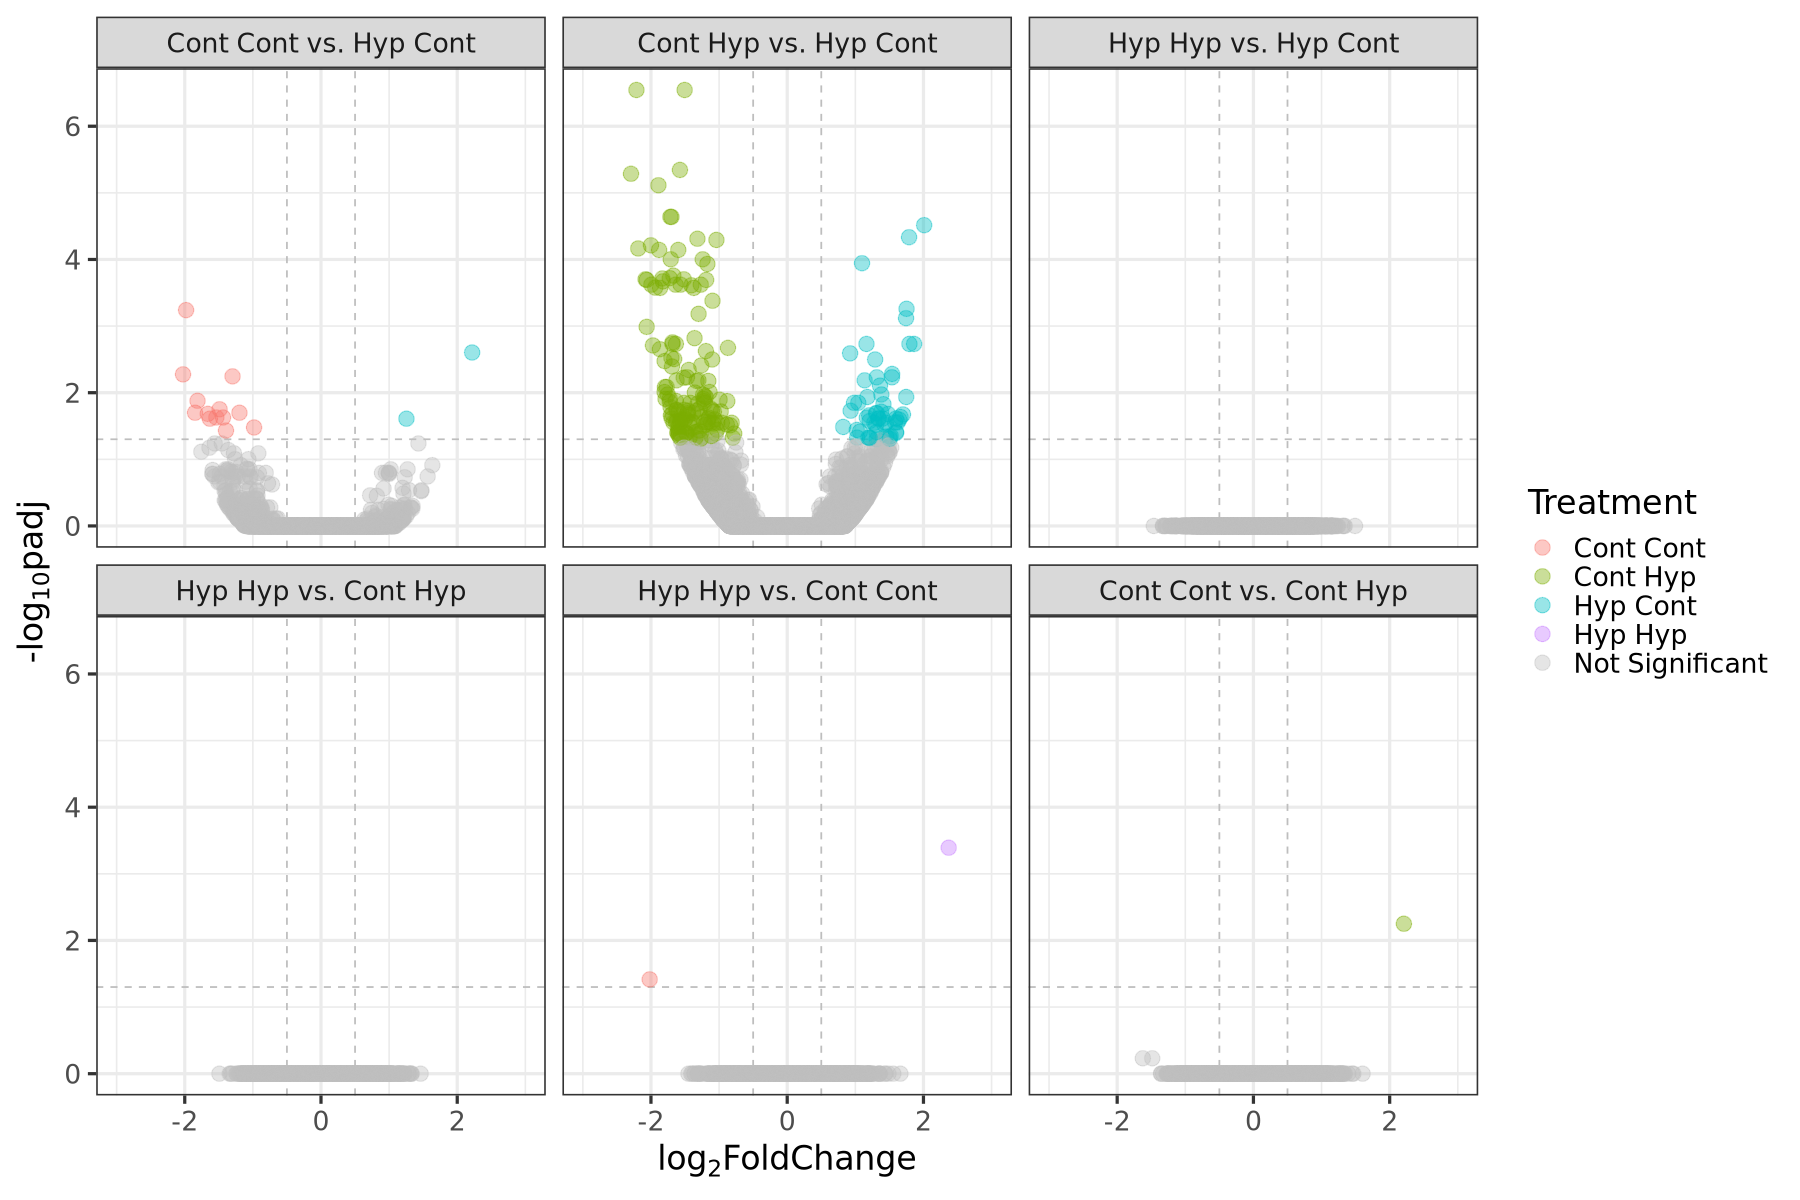

In [35]:
options(repr.plot.width=15, repr.plot.height=10)

# setting order of grids for facet_wrap
mega_df$pair <- factor(mega_df$pair, levels = c('CC_HC','CH_HC','HH_HC', 'HH_CH','HH_CC','CC_CH'))

# renaming grid labels
new_labels <- c(CC_HC = "Cont Cont vs. Hyp Cont", 
                CH_HC = "Cont Hyp vs. Hyp Cont", 
                HH_HC = "Hyp Hyp vs. Hyp Cont",
               HH_CH = "Hyp Hyp vs. Cont Hyp",
               HH_CC = "Hyp Hyp vs. Cont Cont",
               CC_CH = "Cont Cont vs. Cont Hyp")

volcano_MEGA2 <- ggplot(data = mega_df, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
scale_color_manual(values = c('#F8766D','#7CAE00', '#00BFC4', '#C77CFF', 'gray'),
                                           labels=c('Cont Cont','Cont Hyp', 'Hyp Cont', 'Hyp Hyp', 'Not Significant')) + 
facet_wrap(~pair, labeller = as_labeller(new_labels)) + 
                        theme_bw(base_size=20) + 
                        labs(col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano_MEGA2

In [36]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures/metaVolcano2.pdf', volcano_MEGA2,
      width = 15, heigh = 10)

### Venn diagram of all sig. DMGs

In [75]:
head(sig_CH_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111133260,94.62714,-1.240492,0.1868604,-5.300709,1.153541e-07,9.934048e-05
2,LOC111132155,31.57643,-1.683973,0.3147946,-4.555266,5.231936e-06,1.756187e-03
3,LOC111113022,45.87158,-1.865724,0.3249740,-4.971856,6.631506e-07,2.671171e-04
4,LOC111131329,124.64317,-1.140215,0.2199189,-4.047923,5.167408e-05,9.751401e-03
5,LOC111104327,192.47165,-1.103367,0.2237807,-3.813410,1.370624e-04,1.840292e-02
6,LOC111101764,37.63789,-1.339817,0.3121422,-3.491411,4.804761e-04,3.898149e-02


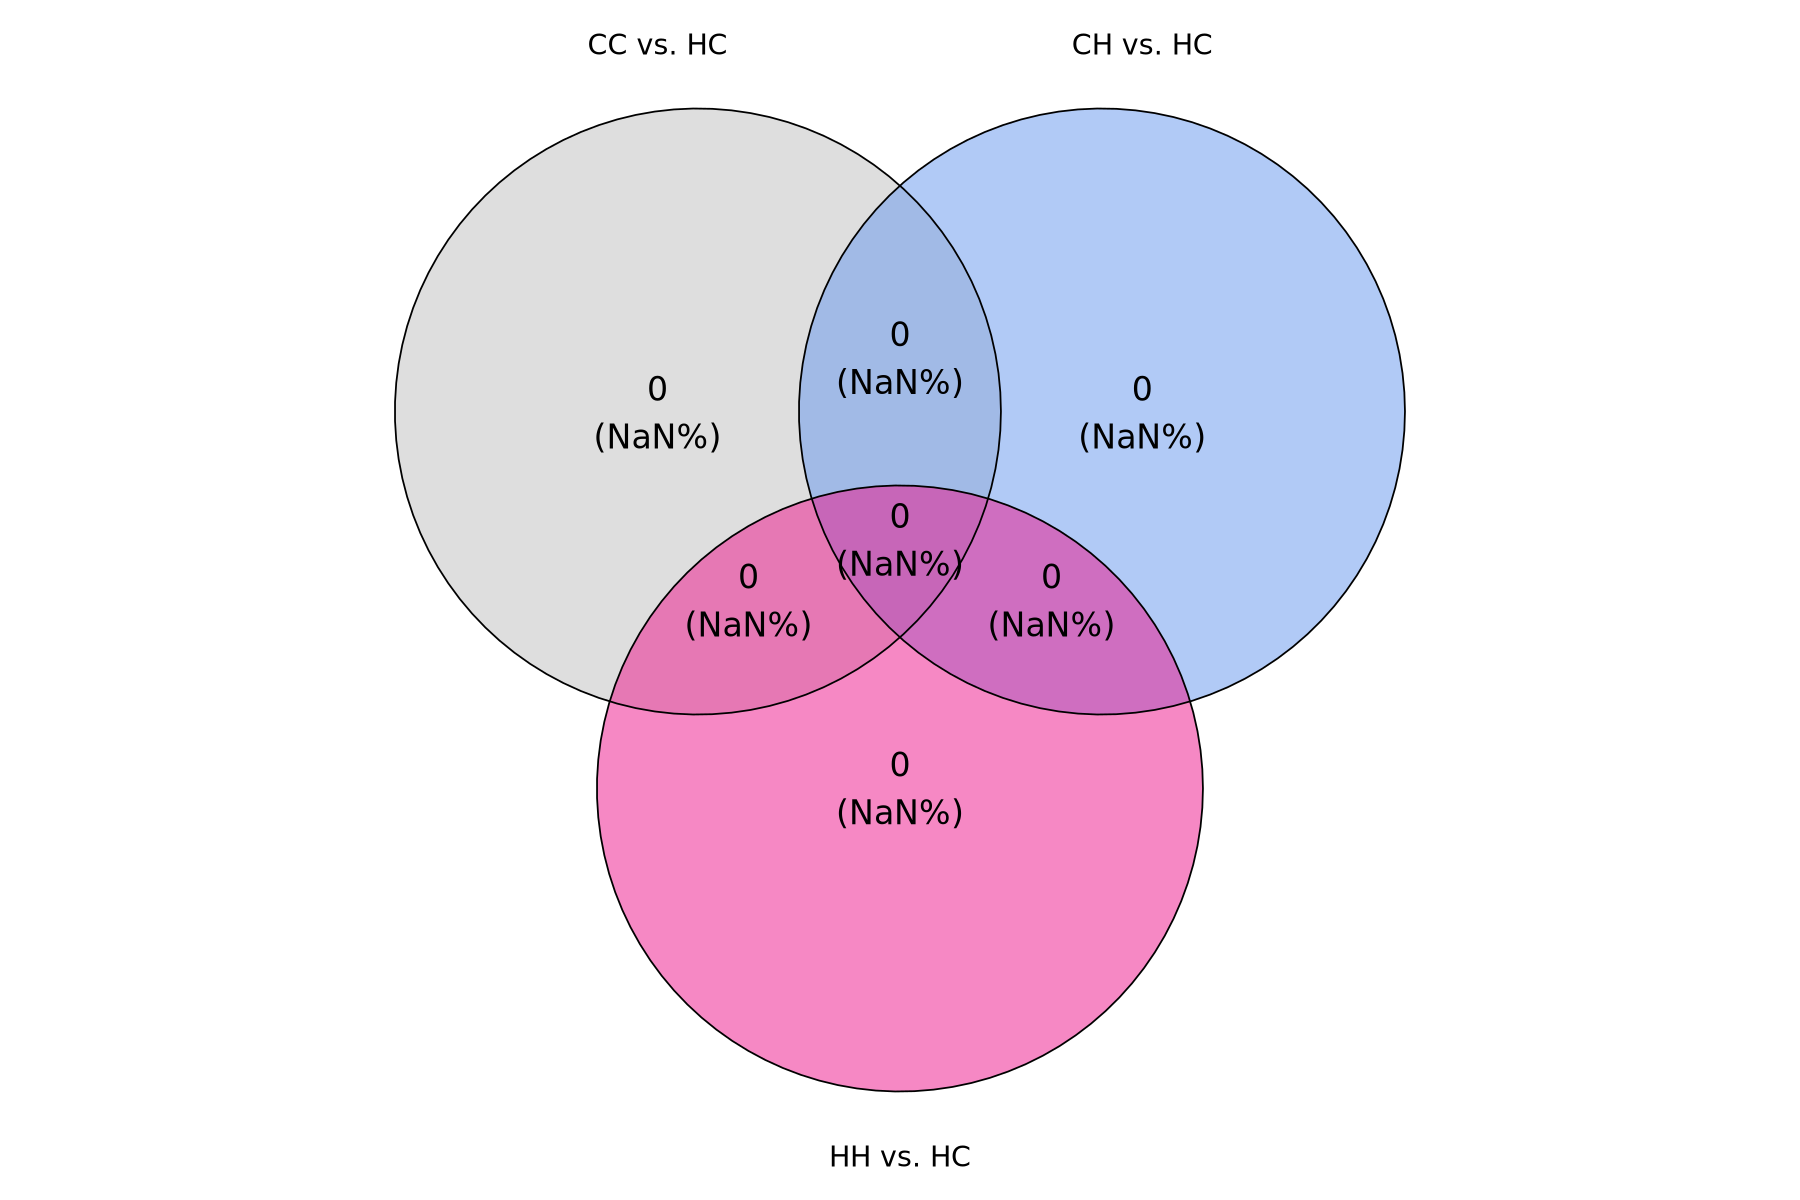

In [76]:

x = list(A = sig_CC_HC$X,
         B = sig_CH_HC$X, 
         C = sig_HH_HC$X)

names(x) <- c('CC vs. HC',
              'CH vs. HC',
              'HH vs. HC')

# same colors as used in the volcano plots
custom_colors <- c('gray',  'cornflowerblue', 'deeppink2')

venn <- ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE,
      fill_color = custom_colors)

venn

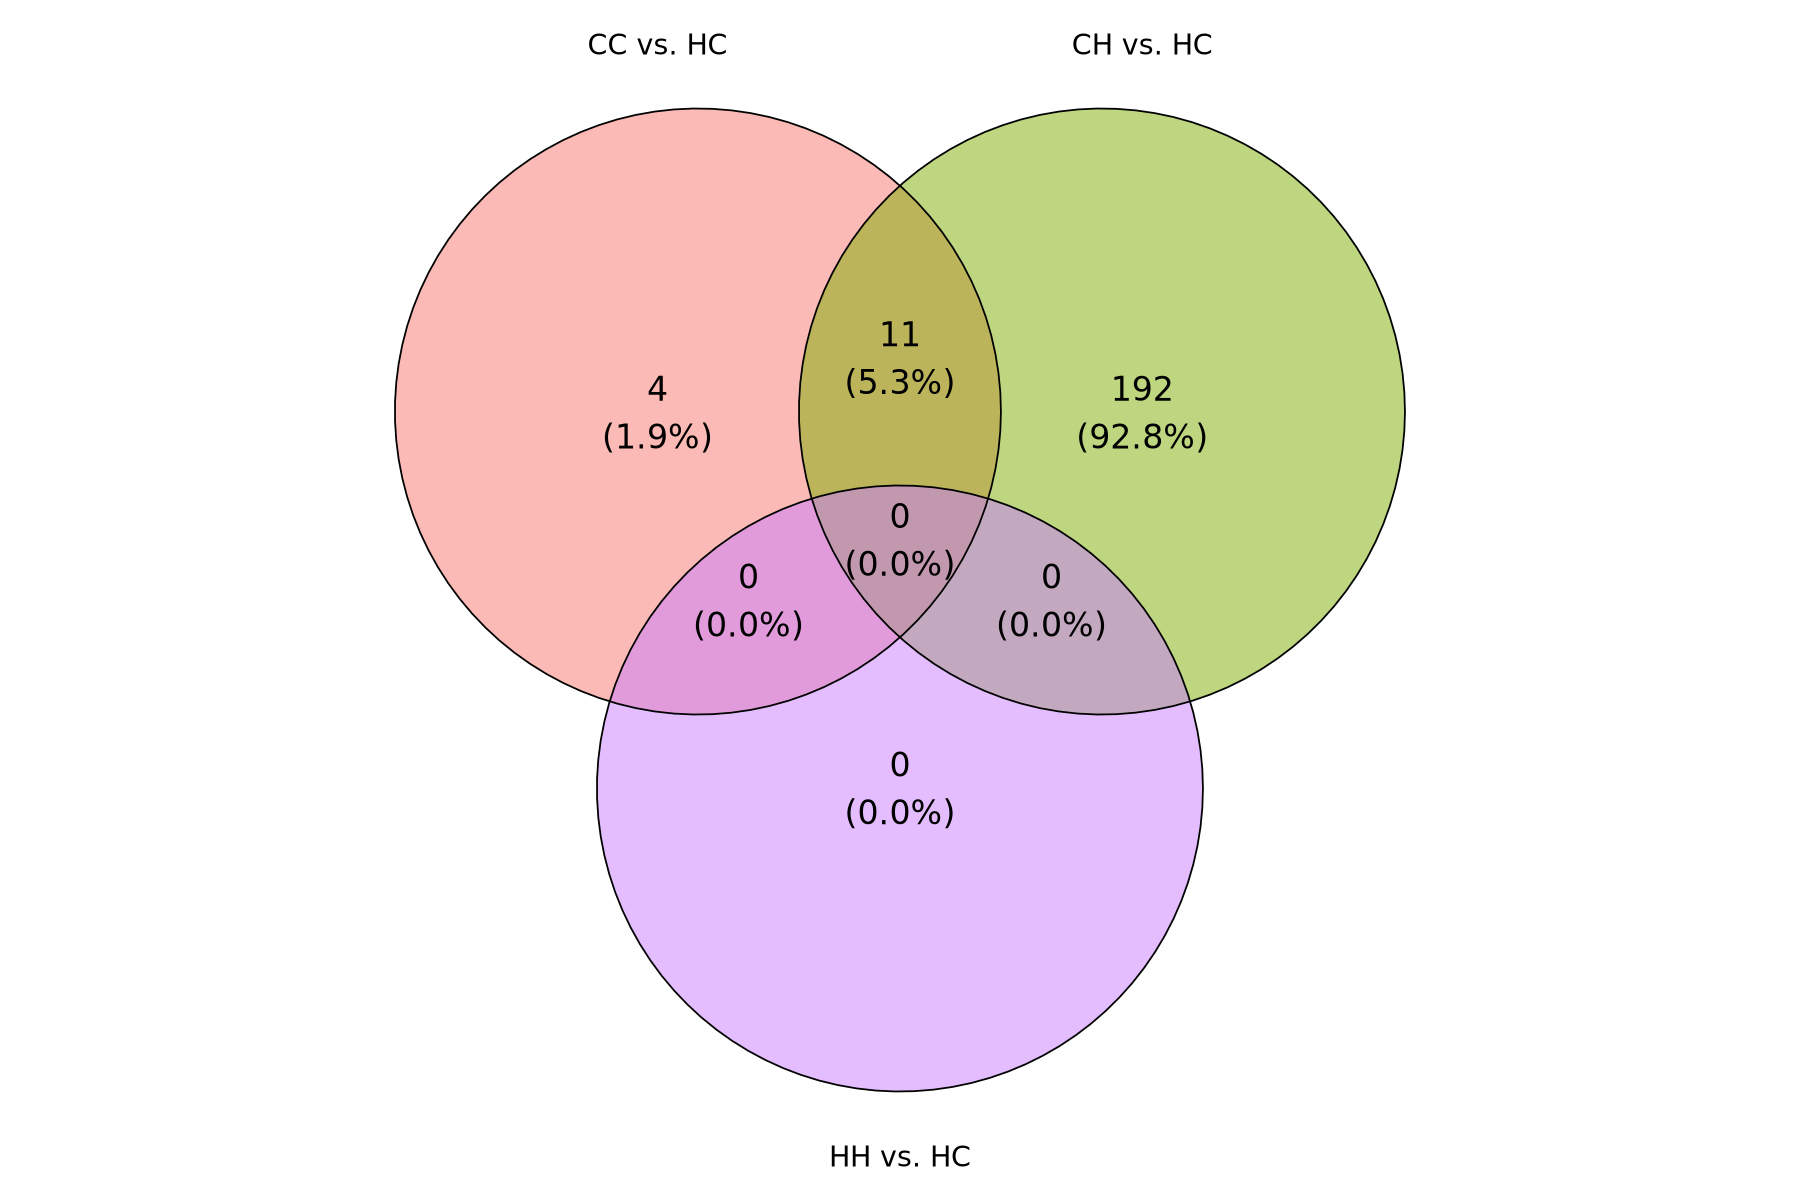

In [77]:

x = list(A = sig_CC_HC$symbol,
         B = sig_CH_HC$symbol, 
         C = sig_HH_HC$symbol)

names(x) <- c('CC vs. HC',
              'CH vs. HC',
              'HH vs. HC')

# same colors as used in the volcano plots
custom_colors <- c('#F8766D',  '#7CAE00', '#C77CFF')

venn <- ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE,
      fill_color = custom_colors)

venn

In [40]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures/DMG_venn.pdf', venn)

Saving 6.67 x 6.67 in image


### shared sig DMGs for the pairwise comparisons

In [41]:
# pulling out the 14 shared genes

# Merge the data frames on the 'gene' column
shared_genes6 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_CH_HC_genes, sig_HH_HC_genes))

shared_genes6 <- as.data.frame(shared_genes6)
                    
# View the result
dim(shared_genes6)


[1]  0 22

In [42]:
shared_genes6

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,⋯,pvalue.y,padj.y,name.y,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>


all of these except for LOC111133438 were in the original analysis - should make a venn diagram of overlap between exon features-to-meta features and new analysis with gene body methylation

In [43]:
write.csv(shared_genes6, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/6shared_genes.csv')

pulling out the **54 shared genes between HH vs. HC and CH vs. HC**

In [44]:
# pulling out the 54 shared genes

# Merge the data frames on the 'gene' column
shared_genes54 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CH_HC_genes, sig_HH_HC_genes))
                    
shared_genes54 <- as.data.frame(shared_genes54)

# View the result
dim(shared_genes54)


[1]  0 15

In [45]:
head(shared_genes54)

symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>


pulling out the **48 genes shared ONLY between HH vs. HC and CH vs. HC**

In [46]:
# to remove the 6 genes that are shared between all the comparisons, and to only look at those shared between just these two...
shared_genes48 <- shared_genes54[!shared_genes54$symbol %in% shared_genes6$symbol, ]
dim(shared_genes48)

[1]  0 15

In [47]:
head(shared_genes48)

symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>


In [48]:
write.csv(shared_genes48, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/48shared_genes.csv')

pulling out the **9 genes shared bewteen CC vs. HC and CH vs. HC**

In [49]:
# pulling out the 9 shared genes

# Merge the data frames on the 'gene' column
shared_genes9 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_CH_HC_genes))  
shared_genes9 <- as.data.frame(shared_genes9)

dim(shared_genes9)

[1] 11 15

In [50]:
head(shared_genes9)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111101872,51.68899,-1.437766,0.2777422,-4.276504,1.898509e-05,0.02355360,"DNA ligase 1-like, transcript variant X3",51.68899,-1.709116,0.2756265,-5.293817,1.197892e-07,9.934048e-05,"DNA ligase 1-like, transcript variant X3"
2,LOC111103344,1000.68234,-1.197207,0.2151155,-4.403251,1.066404e-05,0.01998977,"uncharacterized LOC111103344, transcript variant X7",1000.68234,-1.026149,0.2153397,-3.604298,3.129972e-04,2.828994e-02,"uncharacterized LOC111103344, transcript variant X7"
3,LOC111113022,45.87158,-1.631019,0.3259323,-4.237134,2.263908e-05,0.02456397,uncharacterized protein KIAA0930 homolog,45.87158,-1.865724,0.3249740,-4.971856,6.631506e-07,2.671171e-04,uncharacterized protein KIAA0930 homolog
4,LOC111117760,278.18546,-1.536536,0.2994476,-4.296364,1.736221e-05,0.02355360,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",278.18546,-1.380761,0.2997888,-3.771859,1.620361e-04,2.021579e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
5,LOC111118022,38.79930,-1.848391,0.3646991,-4.382766,1.171819e-05,0.01998977,"exocyst complex component 7-like, transcript variant X1",38.79930,-1.512566,0.3656733,-3.452715,5.549743e-04,4.206467e-02,"exocyst complex component 7-like, transcript variant X1"
6,LOC111119327,26.61984,-1.662187,0.3247317,-4.348781,1.368962e-05,0.02075802,"calcyphosin-like protein, transcript variant X3",26.61984,-2.000122,0.3214908,-5.443770,5.216448e-08,6.128456e-05,"calcyphosin-like protein, transcript variant X3"


pulling out the **3 genes shared between ONLY CC vs. HC and CH vs. HC**

In [51]:
# to remove the 3 genes that are shared between all the comparisons, and to only look at those shared between just these two...
shared_genes3 <- shared_genes9[!shared_genes9$symbol %in% shared_genes6$symbol, ]
dim(shared_genes3)

[1] 11 15

In [52]:
head(shared_genes3)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111101872,51.68899,-1.437766,0.2777422,-4.276504,1.898509e-05,0.02355360,"DNA ligase 1-like, transcript variant X3",51.68899,-1.709116,0.2756265,-5.293817,1.197892e-07,9.934048e-05,"DNA ligase 1-like, transcript variant X3"
2,LOC111103344,1000.68234,-1.197207,0.2151155,-4.403251,1.066404e-05,0.01998977,"uncharacterized LOC111103344, transcript variant X7",1000.68234,-1.026149,0.2153397,-3.604298,3.129972e-04,2.828994e-02,"uncharacterized LOC111103344, transcript variant X7"
3,LOC111113022,45.87158,-1.631019,0.3259323,-4.237134,2.263908e-05,0.02456397,uncharacterized protein KIAA0930 homolog,45.87158,-1.865724,0.3249740,-4.971856,6.631506e-07,2.671171e-04,uncharacterized protein KIAA0930 homolog
4,LOC111117760,278.18546,-1.536536,0.2994476,-4.296364,1.736221e-05,0.02355360,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",278.18546,-1.380761,0.2997888,-3.771859,1.620361e-04,2.021579e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
5,LOC111118022,38.79930,-1.848391,0.3646991,-4.382766,1.171819e-05,0.01998977,"exocyst complex component 7-like, transcript variant X1",38.79930,-1.512566,0.3656733,-3.452715,5.549743e-04,4.206467e-02,"exocyst complex component 7-like, transcript variant X1"
6,LOC111119327,26.61984,-1.662187,0.3247317,-4.348781,1.368962e-05,0.02075802,"calcyphosin-like protein, transcript variant X3",26.61984,-2.000122,0.3214908,-5.443770,5.216448e-08,6.128456e-05,"calcyphosin-like protein, transcript variant X3"


In [53]:
write.csv(shared_genes3, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/3shared_genes.csv')

In [54]:
shared_gene7 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_HH_HC_genes))
shared_gene1 <- shared_gene7[!shared_gene7$symbol %in% shared_genes6$symbol, ]                     
dim(shared_gene1)

[1]  0 15

In [55]:
shared_gene1

symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>


### unique sig DMGs for pairwise comparison

pulling out the **173 unique sig DMGs for CH vs. HC**

In [56]:
unique_CH_HC <- sig_CH_HC_genes[!sig_CH_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes3$symbol, shared_genes48$symbol), ]
dim(unique_CH_HC)

[1] 192   8

In [57]:
head(unique_CH_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,85.93418,-1.268455,0.2026576,-5.025496,5.021318e-07,0.0002389426,kinesin-like protein KIF17
2,LOC111099571,62.21809,-1.386573,0.3153413,-3.604263,3.130394e-04,0.0282899359,histone RNA hairpin-binding protein-like
3,LOC111099930,71.33578,-1.158577,0.2188639,-4.151335,3.305415e-05,0.0066571068,"uncharacterized LOC111099930, transcript variant X1"
4,LOC111099978,74.25643,1.209614,0.2629301,3.649694,2.625531e-04,0.0266293052,"oncoprotein-induced transcript 3 protein-like, transcript variant X1"
5,LOC111100608,45.79652,-1.471241,0.2906827,-4.201284,2.654052e-05,0.0058665565,DDRGK domain-containing protein 1-like
6,LOC111100625,76.87966,-1.218647,0.2664359,-3.635574,2.773624e-04,0.0275258395,"succinate dehydrogenase [ubiquinone] flavoprotein subunit, mitochondrial-like, transcript variant X2"


In [58]:
write.csv(unique_CH_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/139unique_genes_CHvHC.csv')

pulling out the **2 unique sig DMGs for CC vs. HC**

In [59]:
unique_CC_HC <- sig_CC_HC_genes[!sig_CC_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes3$symbol, shared_gene1$symbol), ]
dim(unique_CC_HC)

[1] 4 8

In [60]:
head(unique_CC_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099932,63.22022,1.254333,0.2374474,4.229709,2.339940e-05,0.024563974,exostosin-1a-like
5,LOC111115023,40.66722,-1.394704,0.2789387,-4.103782,4.064501e-05,0.036978828,uncharacterized LOC111115023
6,LOC111115924,10.86816,-2.025111,0.3651334,-4.861541,1.164752e-06,0.005298456,uncharacterized LOC111115924
12,LOC111129122,13.05684,2.218543,0.3870305,5.086273,3.651677e-07,0.002491722,"Bardet-Biedl syndrome 12 protein homolog, transcript variant X2"


In [61]:
write.csv(unique_CC_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/2unique_genes_CCvHC.csv')

pulling out the **22 unique sig DMGs for HH vs. HC**

In [62]:
unique_HH_HC <- sig_HH_HC_genes[!sig_HH_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes48$symbol, shared_gene1$symbol), ]
dim(unique_HH_HC)

[1] 0 8

In [63]:
head(unique_HH_HC)

symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>


In [64]:
write.csv(unique_HH_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/22unique_genes_HHvHC.csv')

Now have multiple dfs that contain shared and unique sig DMGs from the Venn diagram of pairwise comparisons with HC

**Shared sig DMGs**:
- shared_genes14 - shared between all 3 comparisons
- shared_genes67 - shared *ONLY* between HH vs. HC and CH vs. HC
- shared_genes81 - shared between HH vs. HC and CH vs. HC (including the 14 that are shared between all)
- shared_genes18 - shared between CC vs. HC and CH vs. HC (including the 14 that are shared between all)
- shared_genes4 - shared *ONLY* between CC vs. HC and CH vs. HC

**Unique sig DMGs**:
- unique_HH_HC - 43 sig DMGs
- unique_CH_HC - 173 sig DMGs
- unique_CC_HC - 2 sig DMGs

## GO TERMS of DMGs
Assigning functional categories to DMG

This is being done with [g:Profiler](https://cran.r-project.org/web/packages/gprofiler2/vignettes/gprofiler2.html)

I'm mainly using the **g:GOst tool**, which enables functional profiling of gene lists
- ordered_query = FALSE, meaning the order of genes will *not* be taken into account
- significant = TRUE, returns only the statistically significant results


In [65]:
#BiocManager::install("gprofiler2")
library(gprofiler2)

# GO terms of DMGs in pairwise comparisons
looking at signficiantly enriched GO terms for each of the three pairwise comparisons (instead of just looking at the shared or unique terms)

input is all significant DMGs for that pairwise comparison

#### control hypoxic vs. hypoxic control

In [66]:
sigCH_gl <- sig_CH_HC$symbol

resCH <- gost(sigCH_gl, organism = "cvgca002022765v4", significant=TRUE)  
resCH$result

query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
query_1,TRUE,0.003798916,49,57,5,0.0877193,0.10204082,GO:0072594,GO:BP,establishment of protein localization to organelle,9567,17976,GO:00333....
query_1,TRUE,0.009531828,59,57,5,0.0877193,0.08474576,GO:0033365,GO:BP,protein localization to organelle,9567,8456,GO:0008104
query_1,TRUE,0.017138278,511,109,12,0.1100917,0.02348337,GO:0003723,GO:MF,RNA binding,17566,346,GO:0003676
query_1,TRUE,0.036159884,4152,109,43,0.3944954,0.01035645,GO:0097159,GO:MF,organic cyclic compound binding,17566,9069,GO:0005488


for DMG when comparing control hypoxic vs. hypoxic control, a lot of GO terms are significant when it's not ordered - but all seem to have to do with protein localization...

In [67]:
# ordered query
sigCH <- sig_CH_HC[order(sig_CH_HC$log2FC),]

sigCH_gl <- sigCH$symbol

resCH <- gost(sigCH_gl, organism = "cvgca002022765v4", significant=FALSE, ordered_query = TRUE)  
head(resCH$result)

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
1,query_1,FALSE,1,7997,10,2,0.200000000,0.0002500938,GO:0009987,GO:BP,cellular process,9567,3849,GO:0008150
2,query_1,FALSE,1,1506,8,1,0.125000000,0.0006640106,GO:0010467,GO:BP,gene expression,9567,4207,GO:0009059
3,query_1,FALSE,1,712,77,2,0.025974026,0.0028089888,GO:0010468,GO:BP,regulation of gene expression,9567,4208,GO:00104....
4,query_1,FALSE,1,712,77,2,0.025974026,0.0028089888,GO:0010556,GO:BP,regulation of macromolecule biosynthetic process,9567,4258,GO:00090....
5,query_1,FALSE,1,80,148,1,0.006756757,0.0125000000,GO:0010558,GO:BP,negative regulation of macromolecule biosynthetic process,9567,4260,GO:00090....
6,query_1,FALSE,1,4,45,1,0.022222222,0.2500000000,GO:0010569,GO:BP,regulation of double-strand break repair via homologous recombination,9567,4271,GO:00000....


In [68]:
resCH$result$parents <- sapply(resCH$result$parents, function(x) paste(unlist(x), collapse = ","))
write.csv(resCH$result, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/GO_terms/CH_GOres.csv')

reuslts change when you do an ordered query (but still have to do with protein targeting) - ordered query allows you to do a GSEA type of analysis - I ordered by log2FoldChange for the sig DMGs, I wonder if that is correct?

### hypoxic hypoxic vs. hypoxic control

In [69]:
sigHH_gl <- sig_HH_HC$symbol

resHH <- gost(sigHH_gl, organism = "cvgca002022765v4", significant=TRUE)  
resHH$result

Missing query



NULL

In [70]:
# ordered query
sigHH <- sig_HH_HC[order(sig_HH_HC$log2FC),]

sigHH_gl <- sigHH$symbol

resHH <- gost(sigHH_gl, organism = "cvgca002022765v4", significant=FALSE, ordered_query = TRUE)  
head(resHH$result)

Missing query



NULL

In [71]:
resHH$result$parents <- sapply(resHH$result$parents, function(x) paste(unlist(x), collapse = ","))
write.csv(resHH$result, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/GO_terms/HH_GOres.csv')

### control control vs. hypoxic control

In [72]:
sigCC_gl <- sig_CC_HC$symbol

resCC <- gost(sigCC_gl, organism = "cvgca002022765v4", significant=FALSE)  
head(resCC$result)

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
1,query_1,FALSE,0.1496323,3,4,1,0.25,0.333333333,GO:0051131,GO:BP,chaperone-mediated protein complex assembly,9567,13956,GO:0065003
2,query_1,FALSE,0.5976848,12,4,1,0.25,0.083333333,GO:0006887,GO:BP,exocytosis,9567,2572,GO:00161....
3,query_1,FALSE,0.6970802,14,4,1,0.25,0.071428571,GO:0032940,GO:BP,secretion by cell,9567,8206,GO:00469....
4,query_1,FALSE,0.7467546,15,4,1,0.25,0.066666667,GO:0140352,GO:BP,export from cell,9567,20313,GO:00068....
5,query_1,FALSE,1.0000000,769,4,1,0.25,0.001300390,GO:0032774,GO:BP,RNA biosynthetic process,9567,8092,GO:00090....
6,query_1,FALSE,1.0000000,712,4,1,0.25,0.001404494,GO:0031326,GO:BP,regulation of cellular biosynthetic process,9567,7375,GO:00098....


In [73]:
# ordered query
sigCC <- sig_CC_HC[order(sig_CC_HC$log2FC),]

sigCC_gl <- sigCC$symbol

resCC <- gost(sigCC_gl, organism = "cvgca002022765v4", significant=FALSE, ordered_query = TRUE)  
head(resCC$result)

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
1,query_1,FALSE,0.4485214,12,3,1,0.33333333,0.083333333,GO:0006887,GO:BP,exocytosis,9567,2572,GO:00161....
2,query_1,FALSE,0.5231656,14,3,1,0.33333333,0.071428571,GO:0032940,GO:BP,secretion by cell,9567,8206,GO:00469....
3,query_1,FALSE,0.5604759,3,15,1,0.06666667,0.333333333,GO:0051131,GO:BP,chaperone-mediated protein complex assembly,9567,13956,GO:0065003
4,query_1,FALSE,0.5604759,15,3,1,0.33333333,0.066666667,GO:0140352,GO:BP,export from cell,9567,20313,GO:00068....
5,query_1,FALSE,1.0000000,769,11,1,0.09090909,0.001300390,GO:0032774,GO:BP,RNA biosynthetic process,9567,8092,GO:00090....
6,query_1,FALSE,1.0000000,712,11,1,0.09090909,0.001404494,GO:0031326,GO:BP,regulation of cellular biosynthetic process,9567,7375,GO:00098....


In [74]:
resCC$result$parents <- sapply(resCC$result$parents, function(x) paste(unlist(x), collapse = ","))
write.csv(resCC$result, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/GO_terms/CC_GOres.csv')